<a href="https://colab.research.google.com/github/plue1011/ObjectDetection/blob/master/Make_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# パッケージのimport
from math import sqrt
from itertools import product
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [0]:
# 34層にわたる、vggモジュールを作成
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M',
           128, 128, 'M', 
           256, 256, 256, 'MC', 
           512, 512, 512, 'M', 
           512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [0]:
# 8層にわたる、extrasモジュールを作成
def make_extras():
    layers = []
    in_channels = 1024  # vggモジュールから出力された、extraに入力される画像チャネル数

    # extraモジュールの畳み込み層のチャネル数を設定するコンフィギュレーション
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], 1)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Conv2d(cfg[0], cfg[1], 3, stride=2, padding=1)]
    layers += [nn.ReLU(inplace=True)]

    layers += [nn.Conv2d(cfg[1], cfg[2], 1)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Conv2d(cfg[2], cfg[3], 3, stride=2, padding=1)]
    layers += [nn.ReLU(inplace=True)]

    layers += [nn.Conv2d(cfg[3], cfg[4], 1)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Conv2d(cfg[4], cfg[5], 3)]
    layers += [nn.ReLU(inplace=True)]

    layers += [nn.Conv2d(cfg[5], cfg[6], 1)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Conv2d(cfg[6], cfg[7], 3)]
    layers += [nn.ReLU(inplace=True)]

    return nn.ModuleList(layers)

# 動作確認
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU(inplace=True)
)


In [15]:
# デフォルトボックスのオフセットを出力するloc_layersを作成
# オフセット(Δcx, Δcy, Δw, Δh)の値が４つであるため、チャネル数に4をかけている

def make_loc(num_classes=8, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, 3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * 4, 3, padding=1)]

    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2] * 4, 3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3] * 4, 3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4] * 4, 3, padding=1)]

    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5] * 4, 3, padding=1)]

    return nn.ModuleList(loc_layers)


# 動作確認
loc_test = make_loc()
print(loc_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [16]:
# デフォルトボックスに対する各クラスの信頼度confidenceを出力するconf_layersを作成
# デフォルトボックスに対する各クラスの信頼度confidenceを出力するため、クラスの数だけチャネル数が必要

def make_conf(num_classes=8, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    conf_layers = []

    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0] * num_classes, 3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, 3, padding=1)]

    # extraの（source3）に対する畳み込み層
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2] * num_classes, 3, padding=1)]

    # extraの（source4）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3] * num_classes, 3, padding=1)]

    # extraの（source5）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4] * num_classes, 3, padding=1)]

    # extraの（source6）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5] * num_classes, 3, padding=1)]

    return nn.ModuleList(conf_layers)


# 動作確認
conf_test = make_conf()
print(conf_test)

ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# 正規化層

L2ノルムで正規化する処理をする

38*38=1444個の値を512チャネルに渡って、正規化する  
1. 各チャネルの1444個の特徴量をそれぞれ二乗して、512チャネル分を足し合わせてルートを計算する  
2. 上記の値を割り算して正規化する
3. チャネルごとに重み付けする(この512チャネル分の重みは学習するパラメータ)

なぜ行うのか？  
チャネルごとの特徴量の大きさを規格化するため  
あるチャネルの特徴量だけが大きいというような状況を回避するため

スモールサンプルで確かめてみる

バッチ数1, 3チャネルの5*5のデータ

In [58]:
batch_num = 1
channel_num = 3
feature_num = 5

sample_tensor = torch.arange(0, batch_num*channel_num*feature_num*feature_num, 1.).view(batch_num, channel_num, feature_num, feature_num)
print(sample_tensor.shape)
print(sample_tensor)

torch.Size([1, 3, 5, 5])
tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]],

         [[25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.]],

         [[50., 51., 52., 53., 54.],
          [55., 56., 57., 58., 59.],
          [60., 61., 62., 63., 64.],
          [65., 66., 67., 68., 69.],
          [70., 71., 72., 73., 74.]]]])


各要素を二乗する

In [52]:
sample_tensor.pow(2)

tensor([[[[0.0000e+00, 1.0000e+00, 4.0000e+00, 9.0000e+00, 1.6000e+01],
          [2.5000e+01, 3.6000e+01, 4.9000e+01, 6.4000e+01, 8.1000e+01],
          [1.0000e+02, 1.2100e+02, 1.4400e+02, 1.6900e+02, 1.9600e+02],
          [2.2500e+02, 2.5600e+02, 2.8900e+02, 3.2400e+02, 3.6100e+02],
          [4.0000e+02, 4.4100e+02, 4.8400e+02, 5.2900e+02, 5.7600e+02]],

         [[6.2500e+02, 6.7600e+02, 7.2900e+02, 7.8400e+02, 8.4100e+02],
          [9.0000e+02, 9.6100e+02, 1.0240e+03, 1.0890e+03, 1.1560e+03],
          [1.2250e+03, 1.2960e+03, 1.3690e+03, 1.4440e+03, 1.5210e+03],
          [1.6000e+03, 1.6810e+03, 1.7640e+03, 1.8490e+03, 1.9360e+03],
          [2.0250e+03, 2.1160e+03, 2.2090e+03, 2.3040e+03, 2.4010e+03]],

         [[2.5000e+03, 2.6010e+03, 2.7040e+03, 2.8090e+03, 2.9160e+03],
          [3.0250e+03, 3.1360e+03, 3.2490e+03, 3.3640e+03, 3.4810e+03],
          [3.6000e+03, 3.7210e+03, 3.8440e+03, 3.9690e+03, 4.0960e+03],
          [4.2250e+03, 4.3560e+03, 4.4890e+03, 4.6240e+03, 4

チャネルごとに足し合わせる

In [53]:
sample_tensor.pow(2).sum(dim=1, keepdim=True)  # バッチ分だけのデータであるため、チャネルでsumするためにはdim=1とする必要がある

tensor([[[[3125., 3278., 3437., 3602., 3773.],
          [3950., 4133., 4322., 4517., 4718.],
          [4925., 5138., 5357., 5582., 5813.],
          [6050., 6293., 6542., 6797., 7058.],
          [7325., 7598., 7877., 8162., 8453.]]]])

ルートを計算する(後にこの値で割るため、0にならないように1e-10を足している)

In [56]:
norm = sample_tensor.pow(2).sum(dim=1, keepdim=True).sqrt() + 1e-10
norm

tensor([[[[55.9017, 57.2538, 58.6259, 60.0167, 61.4248],
          [62.8490, 64.2884, 65.7419, 67.2086, 68.6877],
          [70.1783, 71.6798, 73.1915, 74.7128, 76.2430],
          [77.7817, 79.3284, 80.8826, 82.4439, 84.0119],
          [85.5862, 87.1665, 88.7525, 90.3438, 91.9402]]]])

各要素を上記の値で割る

In [60]:
x = torch.div(sample_tensor, norm)
x

tensor([[[[0.0000, 0.0175, 0.0341, 0.0500, 0.0651],
          [0.0796, 0.0933, 0.1065, 0.1190, 0.1310],
          [0.1425, 0.1535, 0.1640, 0.1740, 0.1836],
          [0.1928, 0.2017, 0.2102, 0.2183, 0.2262],
          [0.2337, 0.2409, 0.2479, 0.2546, 0.2610]],

         [[0.4472, 0.4541, 0.4605, 0.4665, 0.4721],
          [0.4773, 0.4822, 0.4868, 0.4910, 0.4950],
          [0.4987, 0.5022, 0.5055, 0.5086, 0.5115],
          [0.5143, 0.5168, 0.5193, 0.5216, 0.5237],
          [0.5258, 0.5277, 0.5296, 0.5313, 0.5330]],

         [[0.8944, 0.8908, 0.8870, 0.8831, 0.8791],
          [0.8751, 0.8711, 0.8670, 0.8630, 0.8590],
          [0.8550, 0.8510, 0.8471, 0.8432, 0.8394],
          [0.8357, 0.8320, 0.8284, 0.8248, 0.8213],
          [0.8179, 0.8145, 0.8112, 0.8080, 0.8049]]]])

重み(3パラメータ)

In [63]:
weight = nn.Parameter(torch.Tensor(channel_num))
weight

Parameter containing:
tensor([1.8025e-35, 0.0000e+00, 3.3631e-44], requires_grad=True)

`torch.Size(batch_num, channel_num, feature_num, feature_num)`まで変形する

In [66]:
weights = weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
weights

tensor([[[[1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35],
          [1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35],
          [1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35],
          [1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35],
          [1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35, 1.8025e-35]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44],
          [3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44],
          [3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44],
          [3.3631e-44, 3.3631e-44, 3.3631e-44, 3.3631e-44, 3

重み付けする

In [67]:
weights * x

tensor([[[[0.0000e+00, 3.1482e-37, 6.1491e-37, 9.0099e-37, 1.1738e-36],
          [1.4340e-36, 1.6822e-36, 1.9192e-36, 2.1455e-36, 2.3618e-36],
          [2.5684e-36, 2.7661e-36, 2.9552e-36, 3.1363e-36, 3.3098e-36],
          [3.4760e-36, 3.6355e-36, 3.7885e-36, 3.9354e-36, 4.0765e-36],
          [4.2121e-36, 4.3425e-36, 4.4680e-36, 4.5888e-36, 4.7052e-36]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[2.9427e-44, 2.9427e-44, 2.9427e-44, 2.9427e-44, 2.9427e-44],
          [2.9427e-44, 2.9427e-44, 2.9427e-44, 2.9427e-44, 2.9427e-44],
          [2.9427e-44, 2.8026e-44, 2.8026e-44, 2.8026e-44, 2.8026e-44],
          [2.8026e-44, 2.8026e-44, 2.8026e-44, 2.8026e-44, 2

In [0]:
# convC4_3からの出力をscale=20のL2Normで正規化する層
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 親クラスのコンストラクタ実行
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 係数weightの初期値として設定する値
        self.reset_parameters()  # パラメータの初期化
        self.eps = 1e-10

    def reset_parameters(self):
        '''結合パラメータを大きさscaleの値にする初期化を実行'''
        init.constant_(self.weight, self.scale)  # weightの値がすべてscale（=20）になる

    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''

        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])になります
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形します
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

# デフォルトボックスを出力するクラス

物体にフィットするボックス(バウンディングボックス)の変形元となるデフォルトボックスを作成する

In [0]:
# 変更している(論文を忠実に再現)
# デフォルトボックスを出力するクラス
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 初期設定
        self.image_size = cfg['input_size']  # 画像サイズの300
        # [38, 19, …] 各sourceの特徴量マップのサイズ
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # sourceの個数=6
        self.s_min = cfg['s_min']
        self.s_max = cfg['s_max']
        self.bbox_aspect_num = cfg['bbox_aspect_num']  # 出力するDBoxのアスペクト比の種類
        self.aspect_ratios = cfg['aspect_ratios']  # 長方形のDBoxのアスペクト比

    def make_dbox_list(self):
        '''DBoxを作成する'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # fまでの数で2ペアの組み合わせを作る　f_P_2 個
                # # 特徴量マップ上での座標
                # cx = j + 0.5
                # cy = i + 0.5
                # # 画像上での座標(拡大している)
                # cx *= self.image_size / f
                # cy *= self.image_size / f

                # # DBoxの中心座標 x,y　ただし、0～1で規格化している
                # cx /= self.image_size
                # cy /= self.image_size

                # 上記をまとめると、cx,cyをf(特徴量マップの大きさ)で割れば良いことがわかる
                cx = (j + 0.5) / f
                cy = (i + 0.5) / f

                # 計算式は論文より引用
                s_k = self.s_min + (self.s_max - self.s_min) * k / (self.num_priors - 1)

                aspect_num = self.bbox_aspect_num[k] - 1
                for a in range(aspect_num):
                    ar = self.aspect_ratios[a]

                    # aspect ratioを6種類にするため、大きめの正方形を追加
                    if ar == 1:
                        s_k_one = self.s_min + (self.s_max - self.s_min) * (k+1) / (self.num_priors - 1)
                        s_k_prime = sqrt(s_k * s_k_one)
                        mean += [cx, cy, s_k_prime, s_k_prime]

                    mean += [cx, cy, s_k * sqrt(ar), s_k / sqrt(ar)]



        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxが画像の外にはみ出るのを防ぐため、大きさを最小0、最大1にする
        output.clamp_(max=1, min=0)

        return output

In [169]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}


# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
dbox_df = pd.DataFrame(dbox_list.numpy(), columns=["center_x", "center_y", "w", "h"])
dbox_df

,center_x,center_y,w,h
0,0.013158,0.013158,0.260768,0.260768
1,0.013158,0.013158,0.200000,0.200000
2,0.013158,0.013158,0.282843,0.141421
3,0.013158,0.013158,0.141421,0.282843
4,0.039474,0.013158,0.260768,0.260768
...,...,...,...,...
8727,0.833333,0.833333,0.537401,1.000000
8728,0.500000,0.500000,0.967471,0.967471
8729,0.500000,0.500000,0.900000,0.900000
8730,0.500000,0.500000,1.000000,0.636396


デフォルトボックスの数が8732である理由
* source1の特徴量マップ：38*38
* source2の特徴量マップ：19*19
* source3の特徴量マップ：10*10
* source4の特徴量マップ：5*5
* source5の特徴量マップ：3*3
* source6の特徴量マップ：1*1

ここまでで、
$38\times38+19\times19+10\times10+5\times5+3\times3+1\times1=1940$個のデフォルトボックスができる

また、各特徴量マップに1つのデフォルトボックスではなく、複数のデフォルトボックスがあれば、さらに良くなるのではないかという仮定の下、source1,5,6には4種類のデフォルトボックス、source2,3,4には6種類のデフォルトボックスを用意する

よって、$(38\times38)\times4+(19\times19)\times6+(10\times10)\times6+(5\times5)\times6+(3\times3)\times4+(1\times1)\times4=8732$個のデフォルトボックスとなる

# デフォルトボックスの描画

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -zxf /content/drive/My\ Drive/study/CNN/dataset/RoadDamageDataset.tar.gz

20個のデフォルトボックスをサンプリングして描画

In [217]:
sample_dbox = dbox_df.sample(n=20)
sample_dbox

,center_x,center_y,w,h
53,0.355263,0.013158,0.200000,0.200000
5259,0.592105,0.907895,0.141421,0.282843
7721,0.078947,0.921053,0.340000,0.340000
2885,0.986842,0.486842,0.200000,0.200000
4703,0.934211,0.802632,0.141421,0.282843
2936,0.328947,0.513158,0.260768,0.260768
7205,0.552632,0.657895,0.340000,0.340000
1308,0.618421,0.223684,0.260768,0.260768
5458,0.907895,0.934211,0.282843,0.141421
746,0.907895,0.118421,0.282843,0.141421


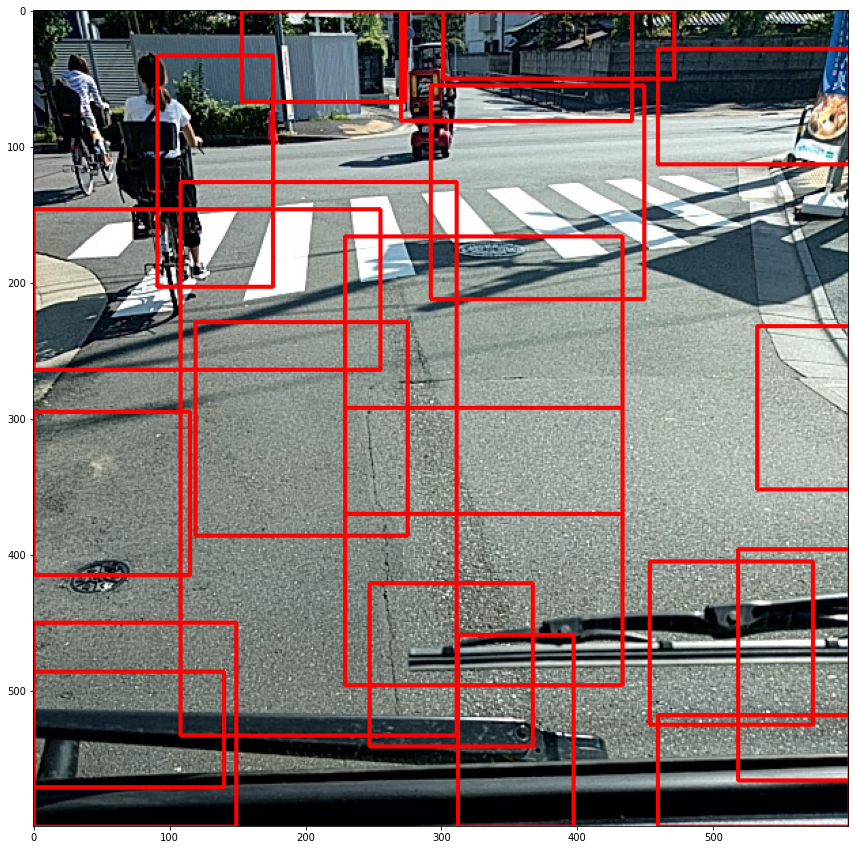

In [218]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

for dbox in sample_dbox.values:
    cx = dbox[0] * W
    cy = dbox[1] * H
    w = dbox[2] * W
    h = dbox[3] * H

    xmin = int(np.clip(cx - w / 2, 0, W))
    xmax = int(np.clip(cx + w / 2, 0, W))
    ymin = int(np.clip(cy - h / 2, 0, H))
    ymax = int(np.clip(cy + h / 2, 0, H))

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

連続するデフォルトボックスを描画

In [238]:
sample_dbox = dbox_df.iloc[6400:6406]
sample_dbox

,center_x,center_y,w,h
6400,0.5,0.289474,0.403980,0.403980
6401,0.5,0.289474,0.340000,0.340000
6402,0.5,0.289474,0.480833,0.240416
6403,0.5,0.289474,0.240416,0.480833
6404,0.5,0.289474,0.588897,0.196299
6405,0.5,0.289474,0.196299,0.588897


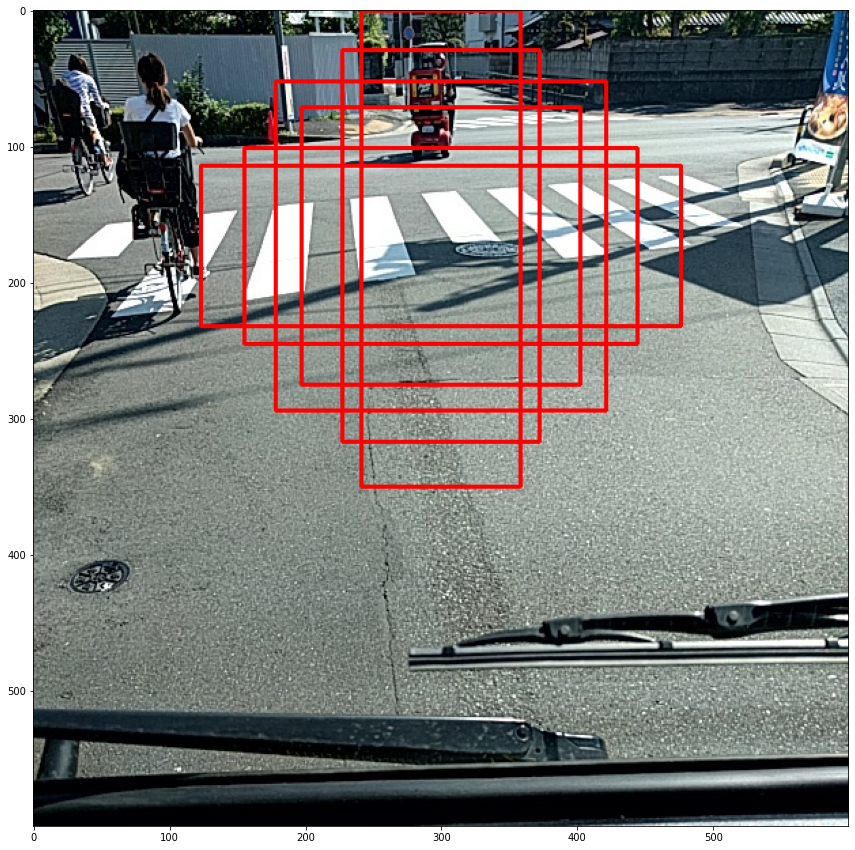

In [239]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

for dbox in sample_dbox.values:
    cx = dbox[0] * W
    cy = dbox[1] * H
    w = dbox[2] * W
    h = dbox[3] * H

    xmin = int(np.clip(cx - w / 2, 0, W))
    xmax = int(np.clip(cx + w / 2, 0, W))
    ymin = int(np.clip(cy - h / 2, 0, H))
    ymax = int(np.clip(cy + h / 2, 0, H))

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()